In [1]:
from binance.client import Client #import binance api
import pandas as pd
import pandas_ta as ta
import numpy as np
import yfinance as yf
import mplfinance as mpf
from scipy.signal import argrelextrema
from docx import Document
from docx.shared import Inches
import requests
import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mdates
from datetime import datetime
import time
from itertools import combinations
from objectes import Indicators
api_key =  'vmPUZE6mv9SD5VNHk4HlWFsOr6aKE2zvsw0MuIgwCIPy6utIco14y7Ju91duEh8A'
api_secret = 'NhqPtmdSJYdKjVHjA7PZj4Mge3R5YNiP1e3UZjInClVN65XAbvqqM6A7H5fATj0j'
client = Client(api_key, api_secret)
token = "7403290101:AAG0FW9A-c-mhGTC1U2RaiVoqFkaWkyFxPU"
Chat_id = "-1002158855846"

In [2]:
def start_end_time():
    timestamp = client._get_earliest_valid_timestamp('BTCUSDT', '1h')
    bars = client.get_historical_klines('BTCUSDT', '1h', timestamp, limit=1000)
    btc_df = pd.DataFrame(bars, columns=['date', 'open', 'high', 'low', 'close','volume','close time','quote asset','number of trades','buy base volume','buy quote volume','ignore'])
    start_time = btc_df['date'].iloc[-96]
    end_time = btc_df['date'].iloc[-1]
    return start_time,end_time


In [3]:
def lines_slops_RSI(main_df, point):
        lineـslope = (main_df["RSI"].iloc[point[1]] - main_df["RSI"].iloc[point[0]]) / (point[1] - point[0])
        epsilon = point[1] - point[0]
        return lineـslope, epsilon

In [4]:
def lines_slops_STO(main_df, point):
        lineـslope = (main_df["STO"].iloc[point[1]] - main_df["STO"].iloc[point[0]]) / (point[1] - point[0])
        epsilon = point[1] - point[0]
        return lineـslope, epsilon

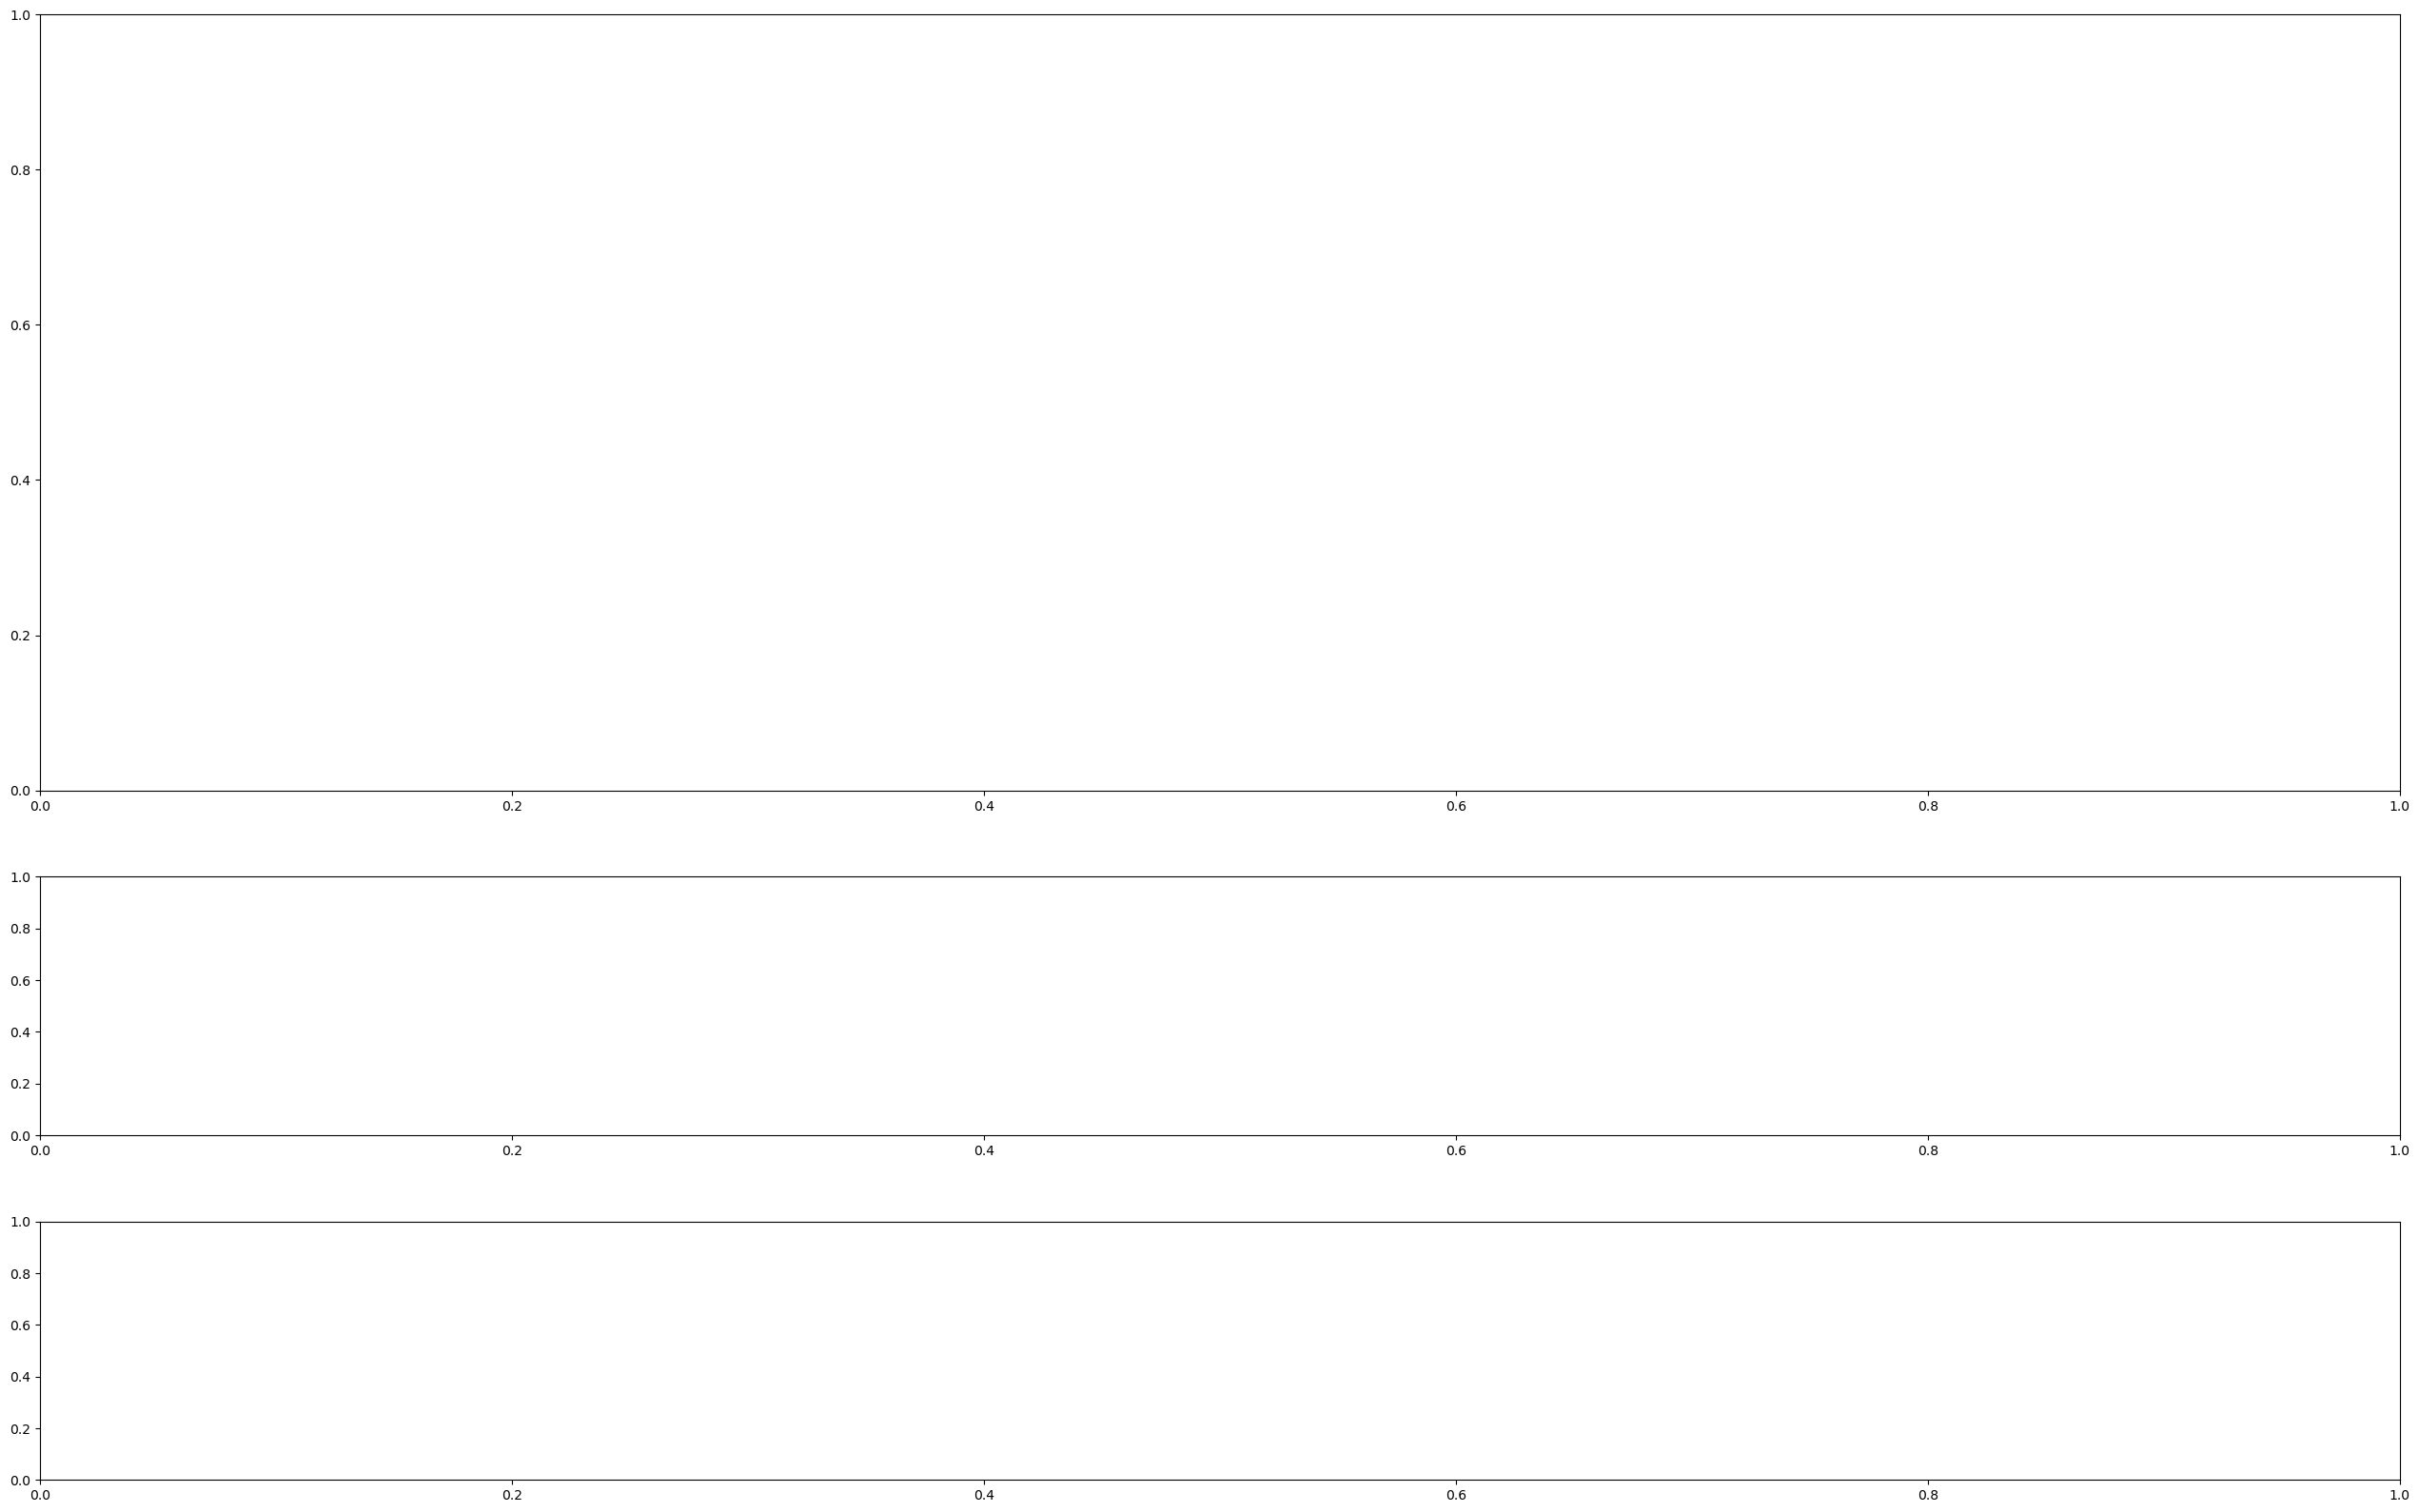

In [5]:
fig, (ax,ax1,ax2) = plt.subplots(3, 1, gridspec_kw={'height_ratios': [3, 1,1]}, figsize=(32, 20)) 
def chandlesPlot(ax,d, o, h, l, c):
    color = []
    for open_p, close_p in zip(o, c):
        if open_p<close_p:
            color.append("g")
        else:
            color.append("r")

    ax.bar(d, height=np.abs(o-c), 
            width=0.8, 
            color=color, 
            bottom=np.min((o, c), axis=0))
    ax.bar(d, height=h-l, width=0.3, color=color, bottom=l)  


In [6]:
def send_image(image_path):
    url = f"https://api.telegram.org/bot{token}/sendPhoto"
    payload = {
        "chat_id": Chat_id,
    }
    files = {
        'photo': open(image_path, 'rb')
    }
    headers = {
        "Accept": "application/json",
    }

    response = requests.post(url, data=payload, files=files, headers=headers)
    return response.json()  # To return the Telegram API's response

# Example usage

In [ ]:
def to_telegram(coin):
    interval = '1h'
    url = f'https://api.binance.com/api/v3/klines'
    params = {
            'symbol': coin,
            'interval': interval,
            'startTime': start_time,
            'endTime': end_time}

                # Set up the request headers with your API key
    headers = {'X-MBX-APIKEY': api_key}

                # Make the API request
    response = requests.get(url, headers=headers, params=params)

                # Check if the request was successful (status code 200)
    if response.status_code == 200:
                    # Parse the response JSON data
        data = response.json()
        ohlc_data = [
                [
                    int(float(entry[0])),  # Convert timestamp to integer
                    float(entry[1]),
                    float(entry[2]),
                    float(entry[3]),
                    float(entry[4])
                ] for entry in data
            ]
    elif response.status_code != 200:
        data = client.futures_historical_klines(symbol = coin ,interval = '1h',start_str  =str(start_time) ,end_str =str(end_time) )
        ohlc_data = [
                [
                    int(float(entry[0])),  # Convert timestamp to integer
                    float(entry[1]),
                    float(entry[2]),
                    float(entry[3]),
                    float(entry[4])
                ] for entry in data
            ]
    # Create a DataFrame with OHLC (Open, High, Low, Close) data and define column names
    df = pd.DataFrame(ohlc_data, columns=['timestamp', 'open', 'high', 'low', 'close'])

    # Apply the Stochastic Oscillator indicator with specified periods, appending it to the DataFrame
    df.ta.stoch(fastk_period=9, slowk_period=3, slowd_period=3, append=True)

    # Drop the slow %D column from Stochastic and rename %K to 'STO' for convenience
    df = df.drop(columns=['STOCHd_14_3_3']).rename(columns={'STOCHk_14_3_3': 'STO'})

    # Set the timestamp as the index and limit DataFrame to the last 500 rows
    df = df.set_index('timestamp')
    df = df[-500:]

    # Reset the index to a simple range index from 0 to the length of df
    df.index = [i for i in range(len(df))]

    # Initialize the Indicators class for technical analysis, passing open, low, high, and close prices
    indicator = Indicators(df["open"], df["low"], df["high"], df["close"])

    # Calculate the Relative Strength Index (RSI) with a 14-period EMA smoothing and add to DataFrame
    df["RSI"] = indicator.RSI(periods=14, ema=True)

    # Create empty columns for storing "down" points for RSI and Stochastic Oscillator
    df["downRSI"] = np.NaN
    df["downSTO"] = np.NaN

    # Loop through DataFrame to identify and mark local minimum points for RSI
    for i in range(len(df)-1): 
        # Check if current RSI value is a local minimum compared to previous three and next point
        if (df["RSI"].iloc[i] < df["RSI"].iloc[i+1] and
            df["RSI"].iloc[i] < df["RSI"].iloc[i-1] and
            df["RSI"].iloc[i] < df["RSI"].iloc[i-2] and
            df["RSI"].iloc[i] < df["RSI"].iloc[i-3]):
            # Assign this RSI value to 'downRSI' column to mark it as a local minimum
            df.loc[i, "downRSI"] = df.loc[i, "RSI"]

    # Loop through DataFrame to identify and mark local minimum points for Stochastic Oscillator
    for i in range(len(df)-1): 
        # Check if current STO value is a local minimum compared to previous three and next point
        if (df["STO"].iloc[i] < df["STO"].iloc[i+1] and
            df["STO"].iloc[i] < df["STO"].iloc[i-1] and
            df["STO"].iloc[i] < df["STO"].iloc[i-2] and
            df["STO"].iloc[i] < df["STO"].iloc[i-3]):
            # Assign this STO value to 'downSTO' column to mark it as a local minimum
            df.loc[i, "downSTO"] = df.loc[i, "STO"]

    # Initialize an empty list to store indices of rows where 'downRSI' has values (local RSI minima)
    get_RSI = []
    for i, val in enumerate(df["downRSI"].notnull()):
        if val:
            get_RSI.append(i)

    # Initialize an empty list to store indices of rows where 'downSTO' has values (local STO minima)
    get_STO = []
    for i, val in enumerate(df["downSTO"].notnull()):
        if val:
            get_STO.append(i)


        # Generate all possible pairs of indices for local minima in RSI and STO lists
    sub_RSI = list(combinations(get_RSI, 2))
    sub_STO = list(combinations(get_STO, 2))

    # Filter pairs to keep only those where the second index is within 60 points of the first
    sub_RSI = [(x, y) for x, y in sub_RSI if x + 60 >= y]
    sub_STO = [(x, y) for x, y in sub_STO if x + 60 >= y]

    # Initialize decay thresholds for slopes and epsilon values
    EPSILON_DECAY = 0
    SLOPES_DECAY = 0

    # Add new columns in DataFrame for buy signals based on RSI and STO analysis
    df['BuyRSI'] = np.NaN
    df['BuySTO'] = np.NaN

    # Loop through each pair in sub_RSI to calculate conditions for generating RSI buy signals
    for i in sub_RSI:
        # Calculate the slope and epsilon for RSI between points in the pair
        slopes, epsilon = lines_slops_RSI(df, i)
        
        # Check if the slope and epsilon satisfy the decay thresholds (positive or negative slopes)
        if (slopes > SLOPES_DECAY and epsilon > EPSILON_DECAY) or (slopes < SLOPES_DECAY and epsilon > EPSILON_DECAY):
            # Check conditions for generating BuyRSI signals based on local minimum and price comparisons
            if ((df['downRSI'].iloc[i[0]] < df['downRSI'].iloc[i[1]]) and (df['close'].iloc[i[0]] > df['close'].iloc[i[1]])) or \
            ((df['downRSI'].iloc[i[0]] < df['downRSI'].iloc[i[1]]) and (df['low'].iloc[i[0]] > df['low'].iloc[i[1]])):
                # Mark buy signal on the 'BuyRSI' column at the second point in the pair
                df.loc[i[1], 'BuyRSI'] = df.loc[i[1], 'close']
            elif ((df['downRSI'].iloc[i[0]] > df['downRSI'].iloc[i[1]]) and (df['close'].iloc[i[0]] < df['close'].iloc[i[1]])) or \
                ((df['downRSI'].iloc[i[0]] > df['downRSI'].iloc[i[1]]) and (df['low'].iloc[i[0]] < df['low'].iloc[i[1]])):
                df.loc[i[1], 'BuyRSI'] = df.loc[i[1], 'close']

    # Loop through each pair in sub_STO to calculate conditions for generating STO buy signals
    for i in sub_STO:
        # Calculate the slope and epsilon for STO between points in the pair
        slopes, epsilon = lines_slops_STO(df, i)
        
        # Check if the slope and epsilon satisfy the decay thresholds (positive or negative slopes)
        if (slopes > SLOPES_DECAY and epsilon > EPSILON_DECAY) or (slopes < SLOPES_DECAY and epsilon > EPSILON_DECAY):
            # Check conditions for generating BuySTO signals based on local minimum and price comparisons
            if ((df['downSTO'].iloc[i[0]] < df['downSTO'].iloc[i[1]]) and (df['close'].iloc[i[0]] > df['close'].iloc[i[1]])) or \
            ((df['downSTO'].iloc[i[0]] < df['downSTO'].iloc[i[1]]) and (df['low'].iloc[i[0]] > df['low'].iloc[i[1]])):
                # Mark buy signal on the 'BuySTO' column at the second point in the pair
                df.loc[i[1], 'BuySTO'] = df.loc[i[1], 'close']
            elif ((df['downSTO'].iloc[i[0]] > df['downSTO'].iloc[i[1]]) and (df['close'].iloc[i[0]] < df['close'].iloc[i[1]])) or \
                ((df['downSTO'].iloc[i[0]] > df['downSTO'].iloc[i[1]]) and (df['low'].iloc[i[0]] < df['low'].iloc[i[1]])):
                df.loc[i[1], 'BuySTO'] = df.loc[i[1], 'close']

    #Search all RSI cover with close price
    sub_RSI = list(combinations(get_RSI, 2))
    sub_STO = list(combinations(get_STO, 2))
    sub_RSI = [(x,y) for x,y in sub_RSI if x+60>=y]
    sub_STO = [(x,y) for x,y in sub_STO if x+60>=y]
    EPSILON_DECAY = 0
    SLOPES_DECAY = 0
    df['BuyRSI'] = np.NaN
    df['BuySTO'] = np.NaN
    for i in sub_RSI:
        slopes, epsilon = lines_slops_RSI(df, i)
        if (slopes>SLOPES_DECAY and epsilon>EPSILON_DECAY) or (slopes<SLOPES_DECAY and epsilon>EPSILON_DECAY) :
            if ((df['downRSI'].iloc[i[0]] < df['downRSI'].iloc[i[1]]) and (df['close'].iloc[i[0]] > df['close'].iloc[i[1]])) or ((df['downRSI'].iloc[i[0]] < df['downRSI'].iloc[i[1]]) and (df['low'].iloc[i[0]] > df['low'].iloc[i[1]])):
                df.loc[i[1], 'BuyRSI'] = df.loc[i[1], 'close']
            elif ((df['downRSI'].iloc[i[0]] > df['downRSI'].iloc[i[1]]) and (df['close'].iloc[i[0]] < df['close'].iloc[i[1]])) or ((df['downRSI'].iloc[i[0]] > df['downRSI'].iloc[i[1]]) and (df['low'].iloc[i[0]] < df['low'].iloc[i[1]])):
                df.loc[i[1], 'BuyRSI'] = df.loc[i[1], 'close']

    for i in sub_STO:
        slopes, epsilon = lines_slops_STO(df, i)
        if (slopes>SLOPES_DECAY and epsilon>EPSILON_DECAY) or (slopes<SLOPES_DECAY and epsilon>EPSILON_DECAY) :
            if ((df['downSTO'].iloc[i[0]] < df['downSTO'].iloc[i[1]]) and (df['close'].iloc[i[0]] > df['close'].iloc[i[1]])) or ((df['downSTO'].iloc[i[0]] < df['downSTO'].iloc[i[1]]) and (df['low'].iloc[i[0]] > df['low'].iloc[i[1]])):
                df.loc[i[1], 'BuySTO'] = df.loc[i[1], 'close']
            elif ((df['downSTO'].iloc[i[0]] > df['downSTO'].iloc[i[1]]) and (df['close'].iloc[i[0]] < df['close'].iloc[i[1]])) or ((df['downSTO'].iloc[i[0]] > df['downSTO'].iloc[i[1]]) and (df['low'].iloc[i[0]] < df['low'].iloc[i[1]])):
                df.loc[i[1], 'BuySTO'] = df.loc[i[1], 'close']

    if pd.notna(df['BuyRSI'].iloc[-2]) == True or pd.notna(df['BuySTO'].iloc[-2]) == True:
        fig, (ax,ax1,ax2) = plt.subplots(3, 1, gridspec_kw={'height_ratios': [3, 1,1]}, figsize=(32, 20)) 
        chandlesPlot(ax,df.index, df["open"], 
                    df["high"], df["low"], 
                    df["close"])
                        # Plot your data on the existing axes
        ax.scatter(df.index, df["BuyRSI"], color="g", linewidths=15, label="BuyRSI")
        ax.scatter(df.index, df["BuySTO"], color="b", linewidths=15, label="BuySTO")
                    
                        # Prepare the upper and lower limit lines
        u = [70 for i in range(len(df))]
        d = [30 for i in range(len(df))]

                        # Plot RSI and the horizontal lines
        ax1.plot(df.index, df.RSI)
        ax1.plot(u, linestyle='--')
        ax1.plot(d, linestyle='--')

        ax2.plot(df.index, df.STO)
        ax2.plot(u, linestyle='--')
        ax2.plot(d, linestyle='--')

                        # Plot additional scatter points
        ax.set_title(f'{coin} Candlestick Data',fontsize=30)
        ax1.scatter(df.index, df["downRSI"],color="g", linewidths=15)
        ax1.set_ylabel('RSI',fontsize=20)
        ax2.scatter(df.index, df["downSTO"],color="b", linewidths=15)
        ax2.set_ylabel('STO',fontsize=20)
                        # Adjust layout to prevent clipping
        fig.tight_layout()

                        # Save the figure as a file
        plt.title(f'{coin} Candlestick Data')
        for_save = '/Users/Ochimaru/trade/'+coin+'.png'
        fig.savefig(for_save)  # Use 'fig.savefig' instead of 'plt.savefig'
        send_image(for_save)
        plt.close()
        return df

In [ ]:
#List coin That interesting and auto run code every one hour
list_coin = ['KSMUSDT','COTIUSDT']
while True:
    now = datetime.now()
    print(now)
    # ตรวจสอบว่าหลักนาทีลงท้ายด้วยเลข 00
    if now.minute % 60 != 0:
      time.sleep(60)
    elif now.minute % 60 == 0:
        start_time,end_time = start_end_time()
        for coin in list_coin:
          to_telegram(coin)
        time.sleep(3420)

2024-11-24 11:55:25.016061
2024-11-24 11:56:25.016079
2024-11-24 11:57:25.016940
2024-11-24 11:58:25.017651
2024-11-24 11:59:25.017875
2024-11-24 12:00:25.017926
2024-11-24 12:57:55.703992
2024-11-24 12:58:55.712727
2024-11-24 12:59:55.713473
2024-11-24 13:00:55.713587
2024-11-24 13:58:50.861748
2024-11-24 13:59:50.867209
2024-11-24 14:00:50.868015
2024-11-24 14:58:21.918814
2024-11-24 14:59:21.924438
2024-11-24 15:00:21.924767
2024-11-24 15:57:53.063548
2024-11-24 15:58:53.066742
2024-11-24 15:59:53.067000
2024-11-24 16:00:53.067372
2024-11-24 16:58:27.497444
2024-11-24 16:59:27.502957
2024-11-24 17:00:27.503365
2024-11-24 17:58:01.479821
2024-11-24 17:59:01.480311
2024-11-24 18:00:01.480649
2024-11-24 18:57:39.681047
2024-11-24 18:58:39.688625
2024-11-24 18:59:39.689001
2024-11-24 19:00:39.689597
2024-11-24 19:58:14.449202
2024-11-24 19:59:14.465553
2024-11-24 20:00:14.465946
2024-11-24 20:57:49.005407
2024-11-24 20:58:49.005883
2024-11-24 20:59:49.006693
2024-11-24 21:00:49.007299
2